In [1]:
import numpy as np
import xarray as xr
import metpy 
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import statsmodels.api as sm
from scipy import stats

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import cartopy.feature as feature

In [74]:
file='/home/jstancz/Desktop/groups/ORC-CLIMATE/aoes_repo/obs/MSWEP_daily/MSWEP_201*.nc'
ds = xr.open_mfdataset(file,combine='nested',concat_dim='time')
ds

<xarray.Dataset> Size: 154MB
Dimensions:    (time: 3652, latitude: 73, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2019-12-31
  * latitude   (latitude) float32 292B -90.0 -87.5 -85.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float32 576B 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
Data variables:
    precip     (time, latitude, longitude) float32 154MB dask.array<chunksize=(365, 73, 144), meta=np.ndarray>

In [75]:
ds

<xarray.Dataset> Size: 154MB
Dimensions:    (time: 3652, latitude: 73, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2019-12-31
  * latitude   (latitude) float32 292B -90.0 -87.5 -85.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float32 576B 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
Data variables:
    precip     (time, latitude, longitude) float32 154MB dask.array<chunksize=(365, 73, 144), meta=np.ndarray>

In [76]:
#Set domain
lon_min = 30
lon_max = 180
lat_max = 30
lat_min = -30

# Slice the dataset for the specified time range and spatial bounds
ds = ds.sel(time=slice('2011-01-01', '2018-03-15'),
                       longitude=slice(lon_min, lon_max),
                       latitude=slice(lat_min, lat_max))

In [77]:
ds_mon = ds.groupby('time.month').mean()
ds_mon

<xarray.Dataset> Size: 74kB
Dimensions:    (month: 12, latitude: 25, longitude: 61)
Coordinates:
  * latitude   (latitude) float32 100B -30.0 -27.5 -25.0 ... 25.0 27.5 30.0
  * longitude  (longitude) float32 244B 30.0 32.5 35.0 ... 175.0 177.5 180.0
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip     (month, latitude, longitude) float32 73kB dask.array<chunksize=(1, 25, 61), meta=np.ndarray>

Text(0.5, 0.98, 'MSWEP Mean Monthly Precipitation from 01/01/2011 to 03/15/2018')

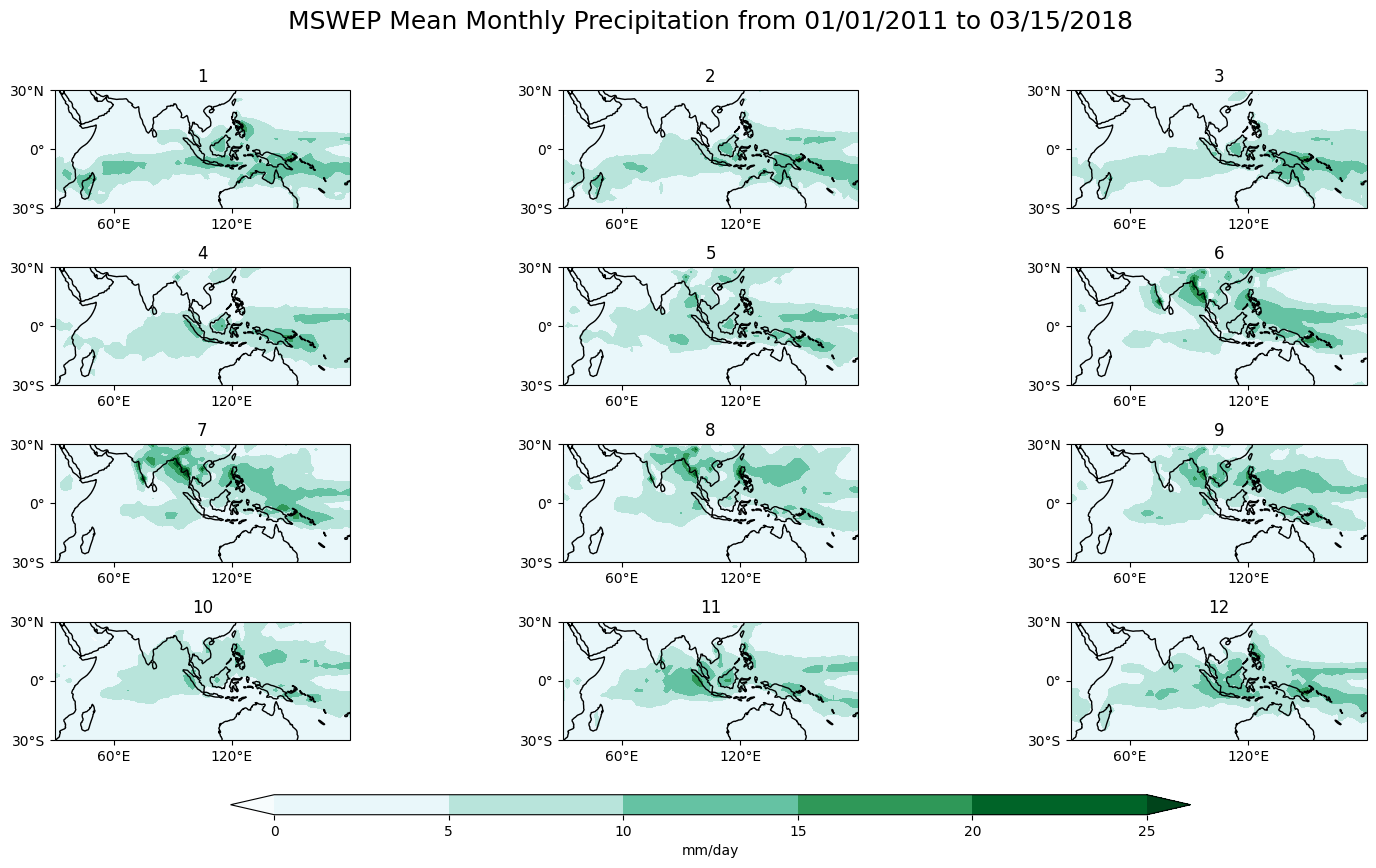

In [81]:
# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,10))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

clevs = np.arange(0, 30, 5)

#Loop over all of the seasons and plot
for i,mon in enumerate(ds_mon['month']):

        # Select the season
        data=ds_mon['precip'].sel(month=mon)

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=ds_mon['longitude'])

        # Contour plot
        cs=axs[i].contourf(lons,ds_mon['latitude'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BuGn',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(0,180,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(lat_min,31,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Title each subplot with the name of the season
        axs[i].set_title(mon.values)
        
        axs[i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
plt.suptitle('MSWEP Mean Monthly Precipitation from 01/01/2011 to 03/15/2018',fontsize=18)